## Obtengo y Preparo Datos 

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.model_selection import KFold

In [6]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

In [7]:
df = pd.read_csv('course_lead_scoring.csv')

In [8]:
df.head(2)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0


In [9]:
df.shape

(1462, 9)

In [10]:
df_0 = df

In [11]:
## Check nulos
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [12]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [13]:
categorical  = ['lead_source', 'industry','employment_status', 'location']

In [14]:
numerical  = ['number_of_courses_viewed', 'annual_income','interaction_count', 'lead_score']

In [15]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

In [16]:
## Check nulos
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

## Divido el dataset

In [17]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_test), len(df_val)

(876, 293, 293)

In [18]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [19]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [20]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

### Question 1

In [21]:
from sklearn.metrics import roc_auc_score

In [22]:
for n in numerical:
    auc = roc_auc_score(y_train,df_train[n])

    print (n, auc)

number_of_courses_viewed 0.7635680590007088
annual_income 0.5519578313253012
interaction_count 0.738270176293409
lead_score 0.6144993577250176


RTA 1: number_of_courses_viewed

### Question 2

In [23]:
dicts = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)
 
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [24]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
## y_pred = model.predict(X_val)

In [25]:
auc = roc_auc_score(y_val,y_pred)
auc

0.8171316268814112

RTA2: Es 0.72

### Question 3: Precision and Recall

In [26]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [27]:
scores = []

thresholds = np.linspace(0,1,101)

for t in thresholds:
    actual_positive = (y_val ==1)
    actual_negative = (y_val == 0)

    predict_positive = y_pred >= t
    predict_negative = y_pred < t

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    fpr = fp/(tn+fp)
    tpr = tp/(tp+fn)

    scores.append((t, tp,tn,fp,fn,fpr,tpr))

In [28]:
columns = ['umbral','tp','tn','fp','fn','fpr','tpr']
df_scores = pd.DataFrame(scores,columns=columns)
df_scores

,umbral,tp,tn,fp,fn,fpr,tpr
0,0.00,171,0,122,0,1.0,1.000000
1,0.01,171,0,122,0,1.0,1.000000
2,0.02,171,0,122,0,1.0,1.000000
3,0.03,171,0,122,0,1.0,1.000000
4,0.04,171,0,122,0,1.0,1.000000
...,...,...,...,...,...,...,...
96,0.96,3,122,0,168,0.0,0.017544
97,0.97,1,122,0,170,0.0,0.005848
98,0.98,0,122,0,171,0.0,0.000000
99,0.99,0,122,0,171,0.0,0.000000


In [29]:
df_scores['precision']=df_scores.tp/(df_scores.tp + df_scores.fp)

In [30]:
df_scores['recall']=df_scores.tp/(df_scores.tp + df_scores.fn)

In [31]:
df_scores[::10]

,umbral,tp,tn,fp,fn,fpr,tpr,precision,recall
0,0.0,171,0,122,0,1.000000,1.000000,0.583618,1.000000
10,0.1,171,0,122,0,1.000000,1.000000,0.583618,1.000000
20,0.2,171,0,122,0,1.000000,1.000000,0.583618,1.000000
30,0.3,171,3,119,0,0.975410,1.000000,0.589655,1.000000
40,0.4,171,17,105,0,0.860656,1.000000,0.619565,1.000000
50,0.5,164,41,81,7,0.663934,0.959064,0.669388,0.959064
60,0.6,150,69,53,21,0.434426,0.877193,0.738916,0.877193
70,0.7,106,97,25,65,0.204918,0.619883,0.809160,0.619883
80,0.8,64,116,6,107,0.049180,0.374269,0.914286,0.374269
90,0.9,24,121,1,147,0.008197,0.140351,0.960000,0.140351


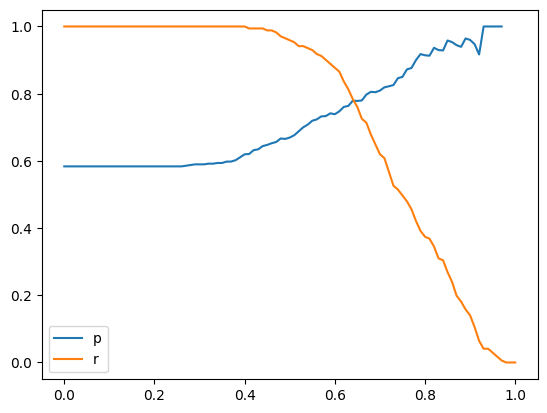

In [32]:
plt.plot(df_scores.umbral, df_scores.precision, label = 'p')
plt.plot(df_scores.umbral, df_scores.recall, label = 'r')
plt.legend()

RTA3: Se cruzan en 0.745

### Question 4: F1 score

In [33]:
df_scores['F1']= ((df_scores.precision * df_scores.recall)/(df_scores.precision + df_scores.recall))*2

In [34]:
df_scores[df_scores.F1 == df_scores.F1.max()]

,umbral,tp,tn,fp,fn,fpr,tpr,precision,recall,F1
57,0.57,156,65,57,15,0.467213,0.912281,0.732394,0.912281,0.8125


RTA 4: es 0.74

### Question 5: 5-Fold CV

In [35]:
categorical = list(df_train.dtypes[df_train.dtypes == 'object'].index)

In [36]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
 
    return dv, model

In [37]:
dv, model = train(df_train, y_train)

In [38]:
def predict(df, dv, model):
     dicts = df[categorical + numerical].to_dict(orient='records')
 
     X = dv.fit_transform(dicts)
     y_pred = model.predict_proba(X)[:,1]
 
     return y_pred

In [39]:
y_pred = predict(df_val, dv, model)

In [41]:
## Entonces, iteramos:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
scores = []
 
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.converted.values
    y_val = df_val.converted.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [42]:
scores

[0.8312537136066548,
 0.7808955223880597,
 0.8551745254133496,
 0.8825417201540436,
 0.7705314009661836,
 0.7787639710716634,
 0.7688271604938272,
 0.8372093023255813,
 0.836734693877551,
 0.8741956241956241]

In [43]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.822 +- 0.041


RTA 5: es 0.06

### Question 6: Hyperparameter Tuning

In [44]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
 
    return dv, model

In [45]:
dv, model = train(df_train, y_train, C=10)

In [46]:
def predict(df, dv, model):
     dicts = df[categorical + numerical].to_dict(orient='records')
 
     X = dv.fit_transform(dicts)
     y_pred = model.predict_proba(X)[:,1]
 
     return y_pred

In [47]:
y_pred = predict(df_val, dv, model)

In [49]:
## Entonces, iteramos:

n_splits = 5

for C in [0.000001, 0.001, 1]:

    scores = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state =1)
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.converted.values
        y_val = df_val.converted.values
    
        dv,model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
                    
    print('C=%s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))   

C=1e-06, 0.560 +- 0.024
C=0.001, 0.867 +- 0.029
C=1, 0.822 +- 0.036


RTA 6: 0.001